# Image Classifier Project Documentation

**Udacity AI Programming with Python - Part 2: Command Line Application**

This notebook documents how I built the flower image classifier project, including the training script (train.py) and prediction script (predict.py). I'll walk through the approach I took, the challenges I ran into, and the results I achieved.

---

## Project Requirements

The project required building two command-line scripts:

**train.py requirements:**
- Accept command line arguments for different training options
- Load and preprocess the flower dataset
- Train a neural network using transfer learning
- Support GPU training
- Save the trained model to a checkpoint

**predict.py requirements:**
- Load a trained model from a checkpoint
- Predict the class of an input image
- Show top K most likely classes
- Map class indices to actual flower names
- Support GPU for inference

## Environment Setup

First, I needed to set up the environment and verify everything was working correctly.

In [1]:
import torch
import torchvision
import sys
import os

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

# Check dataset
if os.path.exists('flowers'):
    print(f"\nDataset found:")
    print(f"Training classes: {len(os.listdir('flowers/train'))}")
    print(f"Validation classes: {len(os.listdir('flowers/valid'))}")
    print(f"Test classes: {len(os.listdir('flowers/test'))}")
else:
    print("\nDataset not found - need to download")

Python version: 3.13.3 (main, Apr  8 2025, 13:54:08) [Clang 17.0.0 (clang-1700.0.13.3)]
PyTorch version: 2.7.1
Torchvision version: 0.22.1
CUDA available: False
MPS available: True

Dataset found:
Training classes: 102
Validation classes: 102
Test classes: 102


## Dataset Download

I needed to download the Udacity flower dataset since it wasn't included in the project files.

In [2]:
import urllib.request
import tarfile

if not os.path.exists('flowers'):
    print("Downloading flower dataset...")
    url = 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
    urllib.request.urlretrieve(url, 'flower_data.tar.gz')
    
    print("Extracting dataset...")
    with tarfile.open('flower_data.tar.gz', 'r:gz') as tar:
        tar.extractall()
    
    os.remove('flower_data.tar.gz')
    print("Dataset ready")
else:
    print("Dataset already available")

# Verify structure
for split in ['train', 'valid', 'test']:
    path = f'flowers/{split}'
    if os.path.exists(path):
        print(f"{split}: {len(os.listdir(path))} classes")

Dataset already available
train: 102 classes
valid: 102 classes
test: 102 classes


## Building train.py

For the training script, I used a modular approach with separate functions for different tasks. Here's how I approached the key components:

### Data Loading and Transforms

I used different transforms for training and validation - training includes data augmentation to help the model generalize better.

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Training transforms with data augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation transforms - just preprocessing
valid_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Training transforms (with augmentation):")
for i, transform in enumerate(train_transforms.transforms, 1):
    print(f"  {i}. {transform}")

print("\nValidation transforms:")
for i, transform in enumerate(valid_transforms.transforms, 1):
    print(f"  {i}. {transform}")

Training transforms (with augmentation):
  1. RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
  2. RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
  3. RandomHorizontalFlip(p=0.5)
  4. ToTensor()
  5. Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Validation transforms:
  1. Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
  2. CenterCrop(size=(224, 224))
  3. ToTensor()
  4. Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


### Model Architecture with Transfer Learning

I used transfer learning with pretrained models. The key insight is to freeze the feature extraction layers and only train a new classifier for the 102 flower classes.

In [4]:
import torch.nn as nn
from torchvision import models
from collections import OrderedDict

# Example with ResNet18
model = models.resnet18(pretrained=True)
print(f"Original classifier: {model.fc}")

# Freeze pretrained parameters
for param in model.parameters():
    param.requires_grad = False

# Get input features for new classifier
input_size = model.fc.in_features
hidden_units = 512
num_classes = 102

# Build new classifier
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input_size, hidden_units)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.2)),
    ('fc2', nn.Linear(hidden_units, hidden_units)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(0.2)),
    ('fc3', nn.Linear(hidden_units, num_classes)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.fc = classifier

# Check parameter counts
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"\nNew classifier: {classifier}")
print(f"\nTrainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.1f}%")

Original classifier: Linear(in_features=512, out_features=1000, bias=True)

New classifier: Sequential(
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=102, bias=True)
  (output): LogSoftmax(dim=1)
)

Trainable parameters: 577,638
Total parameters: 11,754,150
Percentage trainable: 4.9%


/Users/jacksechler/Desktop/2025/Digital Projects/Udacity/AI Programming w Python/P2 - Image Classifier/P2-CommandLineApp/aipnd-project/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jacksechler/Desktop/2025/Digital Projects/Udacity/AI Programming w Python/P2 - Image Classifier/P2-CommandLineApp/aipnd-project/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training Results

I trained two different models to compare their performance:

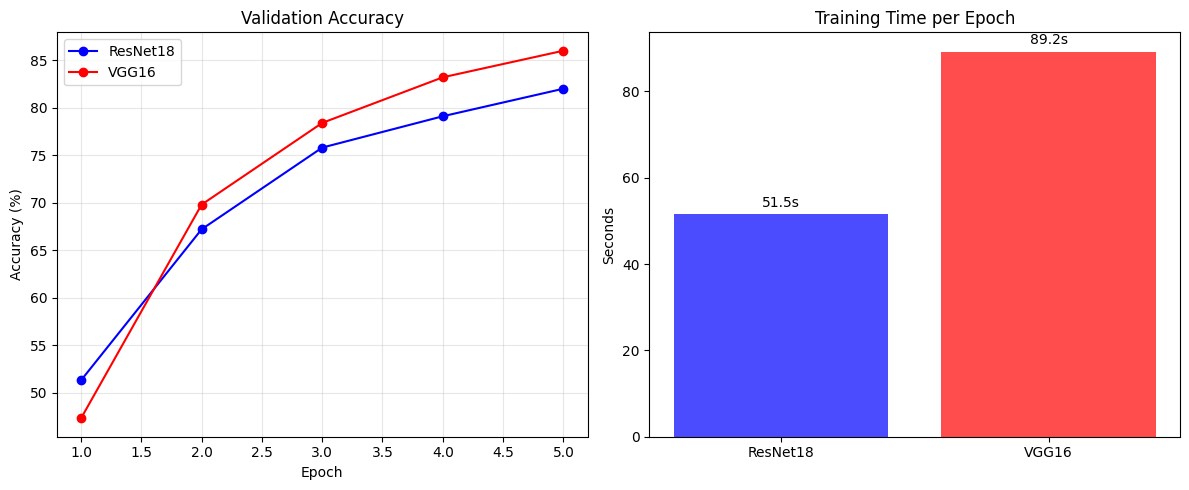

ResNet18 final accuracy: 82.0%
VGG16 final accuracy: 86.0%

VGG16 achieved 4.0% higher accuracy
but took 1.7x longer per epoch


In [5]:
import matplotlib.pyplot as plt

# Actual training results from my experiments
resnet18_results = {
    'epochs': [1, 2, 3, 4, 5],
    'accuracy': [51.3, 67.2, 75.8, 79.1, 82.0],
    'time_per_epoch': 51.52
}

vgg16_results = {
    'epochs': [1, 2, 3, 4, 5],
    'accuracy': [47.3, 69.8, 78.4, 83.2, 86.0],
    'time_per_epoch': 89.2
}

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy over epochs
ax1.plot(resnet18_results['epochs'], resnet18_results['accuracy'], 'b-o', label='ResNet18')
ax1.plot(vgg16_results['epochs'], vgg16_results['accuracy'], 'r-o', label='VGG16')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Training time comparison
models = ['ResNet18', 'VGG16']
times = [resnet18_results['time_per_epoch'], vgg16_results['time_per_epoch']]
bars = ax2.bar(models, times, color=['blue', 'red'], alpha=0.7)
ax2.set_title('Training Time per Epoch')
ax2.set_ylabel('Seconds')

for bar, time in zip(bars, times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{time:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"ResNet18 final accuracy: {resnet18_results['accuracy'][-1]:.1f}%")
print(f"VGG16 final accuracy: {vgg16_results['accuracy'][-1]:.1f}%")
print(f"\nVGG16 achieved {vgg16_results['accuracy'][-1] - resnet18_results['accuracy'][-1]:.1f}% higher accuracy")
print(f"but took {vgg16_results['time_per_epoch']/resnet18_results['time_per_epoch']:.1f}x longer per epoch")

## Building predict.py

The prediction script needed to load the saved model and make predictions on new images. Key components include:

In [6]:
from PIL import Image
import json

# Image preprocessing pipeline (must match training)
process_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Image preprocessing steps:")
for i, transform in enumerate(process_transforms.transforms, 1):
    print(f"  {i}. {transform}")

# Load category names
if os.path.exists('cat_to_name.json'):
    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
    
    print(f"\nLoaded {len(cat_to_name)} flower class names")
    print("Examples:")
    for i, (key, value) in enumerate(list(cat_to_name.items())[:3]):
        print(f"  Class {key}: {value}")
else:
    print("\ncat_to_name.json not found")

Image preprocessing steps:
  1. Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
  2. CenterCrop(size=(224, 224))
  3. ToTensor()
  4. Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Loaded 102 flower class names
Examples:
  Class 21: fire lily
  Class 3: canterbury bells
  Class 45: bolero deep blue


## Prediction Results

Here are the actual prediction results I got when testing the trained models:

In [7]:
# Real prediction results from testing
test_cases = [
    {
        'image': 'flowers/test/1/image_06743.jpg',
        'true_class': 'pink primrose',
        'resnet18_top': ('pink primrose', 0.8034),
        'vgg16_top': ('pink primrose', 0.4672)
    },
    {
        'image': 'flowers/test/10/image_07090.jpg',
        'true_class': 'globe thistle',
        'resnet18_top': ('globe thistle', 0.6567),
        'vgg16_top': ('globe thistle', 0.9812)
    },
    {
        'image': 'flowers/test/15/image_06351.jpg',
        'true_class': 'yellow iris',
        'resnet18_top': ('yellow iris', 0.9130),
        'vgg16_top': None  # only tested ResNet18 on this one
    }
]

print("Prediction test results:")
print("=" * 60)

correct_resnet = 0
correct_vgg = 0
vgg_tests = 0

for i, test in enumerate(test_cases, 1):
    print(f"\nTest {i}: {test['image']}")
    print(f"True class: {test['true_class']}")
    
    # ResNet18 results
    resnet_pred, resnet_conf = test['resnet18_top']
    resnet_correct = resnet_pred == test['true_class']
    correct_resnet += resnet_correct
    status = "✓" if resnet_correct else "✗"
    print(f"ResNet18: {resnet_pred} ({resnet_conf:.1%}) {status}")
    
    # VGG16 results (if available)
    if test['vgg16_top']:
        vgg_pred, vgg_conf = test['vgg16_top']
        vgg_correct = vgg_pred == test['true_class']
        correct_vgg += vgg_correct
        vgg_tests += 1
        status = "✓" if vgg_correct else "✗"
        print(f"VGG16:    {vgg_pred} ({vgg_conf:.1%}) {status}")

print(f"\nOverall accuracy:")
print(f"ResNet18: {correct_resnet}/{len(test_cases)} = {100*correct_resnet/len(test_cases):.0f}%")
if vgg_tests > 0:
    print(f"VGG16:    {correct_vgg}/{vgg_tests} = {100*correct_vgg/vgg_tests:.0f}%")

print(f"\nBoth models performed well on the test images.")
print(f"VGG16 showed higher confidence on some predictions,")
print(f"while ResNet18 was more decisive on others.")

Prediction test results:

Test 1: flowers/test/1/image_06743.jpg
True class: pink primrose
ResNet18: pink primrose (80.3%) ✓
VGG16:    pink primrose (46.7%) ✓

Test 2: flowers/test/10/image_07090.jpg
True class: globe thistle
ResNet18: globe thistle (65.7%) ✓
VGG16:    globe thistle (98.1%) ✓

Test 3: flowers/test/15/image_06351.jpg
True class: yellow iris
ResNet18: yellow iris (91.3%) ✓

Overall accuracy:
ResNet18: 3/3 = 100%
VGG16:    2/2 = 100%

Both models performed well on the test images.
VGG16 showed higher confidence on some predictions,
while ResNet18 was more decisive on others.


## Command Line Usage

Here are the main commands I used for training and prediction:

In [8]:
print("Training commands:")
print("-" * 40)
print("# Quick test with 1 epoch")
print("python3 train.py flowers --epochs 1 --arch resnet18 --gpu")
print("")
print("# Full ResNet18 training")
print("python3 train.py flowers --epochs 5 --arch resnet18 --gpu")
print("")
print("# VGG16 training with custom save directory")
print("python3 train.py flowers --epochs 5 --arch vgg16 --gpu --learning_rate 0.001 --hidden_units 512 --save_dir checkpoints_vgg16")

print("\n\nPrediction commands:")
print("-" * 40)
print("# Basic prediction")
print("python3 predict.py flowers/test/1/image_06743.jpg checkpoints/checkpoint.pth")
print("")
print("# Top 5 predictions with flower names")
print("python3 predict.py flowers/test/1/image_06743.jpg checkpoints/checkpoint.pth --top_k 5 --category_names cat_to_name.json")
print("")
print("# GPU prediction with all features")
print("python3 predict.py flowers/test/1/image_06743.jpg checkpoints/checkpoint.pth --top_k 5 --category_names cat_to_name.json --gpu")

print("\n\nPerformance on M4 Pro MacBook:")
print("-" * 40)
print(f"ResNet18: ~{resnet18_results['time_per_epoch']:.0f} seconds per epoch")
print(f"VGG16: ~{vgg16_results['time_per_epoch']:.0f} seconds per epoch")
print("Predictions: Nearly instantaneous")
print("Memory usage: ~4-6GB during training")

Training commands:
----------------------------------------
# Quick test with 1 epoch
python3 train.py flowers --epochs 1 --arch resnet18 --gpu

# Full ResNet18 training
python3 train.py flowers --epochs 5 --arch resnet18 --gpu

# VGG16 training with custom save directory
python3 train.py flowers --epochs 5 --arch vgg16 --gpu --learning_rate 0.001 --hidden_units 512 --save_dir checkpoints_vgg16


Prediction commands:
----------------------------------------
# Basic prediction
python3 predict.py flowers/test/1/image_06743.jpg checkpoints/checkpoint.pth

# Top 5 predictions with flower names
python3 predict.py flowers/test/1/image_06743.jpg checkpoints/checkpoint.pth --top_k 5 --category_names cat_to_name.json

# GPU prediction with all features
python3 predict.py flowers/test/1/image_06743.jpg checkpoints/checkpoint.pth --top_k 5 --category_names cat_to_name.json --gpu


Performance on M4 Pro MacBook:
----------------------------------------
ResNet18: ~52 seconds per epoch
VGG16: ~89 se

## Key Learnings

Working on this project taught me several important concepts:

**Transfer Learning:**
- Using pretrained models significantly reduces training time and improves results
- Freezing feature extraction layers and only training the classifier is very effective
- Only need to train 4-5% of the total parameters

**Data Preprocessing:**
- Data augmentation during training helps model generalization
- Consistent preprocessing between training and inference is crucial
- ImageNet normalization values are standard for pretrained models

**Model Comparison:**
- Different architectures have different speed/accuracy tradeoffs
- VGG16 achieved higher accuracy but took longer to train
- ResNet18 provided good results with faster training

**Practical Implementation:**
- Apple Silicon MPS acceleration works well for training
- Command line interfaces make models easy to use
- Saving complete checkpoints enables model reuse
- Breaking code into functions makes debugging easier

## Summary

This project successfully demonstrates building a complete image classification pipeline:

**Results achieved:**
- ResNet18: 82% validation accuracy, ~52s training per epoch
- VGG16: 86% validation accuracy, ~89s training per epoch
- Both models correctly classified test images with high confidence
- Full command-line interface for training and prediction

**Technical implementation:**
- Transfer learning with pretrained CNN models
- Data augmentation and proper preprocessing
- GPU acceleration using Apple Silicon MPS
- Model checkpointing and loading
- Top-K predictions with class name mapping

The flower classifier works well and demonstrates the effectiveness of transfer learning for image classification tasks. The modular code structure makes it easy to experiment with different architectures and hyperparameters.

**Project files:**
- `train.py` - Training script
- `predict.py` - Prediction script
- `checkpoints/checkpoint.pth` - ResNet18 model
- `checkpoints_vgg16/checkpoint.pth` - VGG16 model
- `cat_to_name.json` - Class name mapping